In [1]:
CATEGORY = 'giraffe' # 'car', 'apple'

In [2]:
FILE = '7361' + '.png'

---

In [3]:
LABEL_PREFIX = 'sketch of a'

GRIDCELL_SIZE = 5
GRID_WIDTH = 50
GRID_HEIGHT = 50

RENDER_W_GRID = False

N_LABELS = 10
SEED = 5 # None

OVERWRITE = True

In [ ]:
MODEL = 'ViT-B/16'

In [4]:
FRAMES = 10000
INTERVAL = 5 # ms

# Imports

In [5]:
import os
from pathlib import Path

In [6]:
from itertools import product
from functools import reduce

In [7]:
import numpy as np

In [8]:
import torch

In [9]:
import clip

In [10]:
from PIL import Image, ImageDraw, ImageOps
import skimage

In [11]:
from tqdm import tqdm

In [12]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [13]:
import pickle

In [14]:
import logging

In [15]:
import gc

---

In [16]:
from imagelib import Im

---

In [17]:
# Autoreload Custom Modules
%load_ext autoreload
%autoreload 1

In [18]:
# Utilities
%aimport imagelib

## Configs

In [19]:
logging.basicConfig(level=logging.WARNING)

In [20]:
device = 'cpu' # 'cuda' if torch.cuda.is_available() else 'cpu'

In [21]:
if device == 'cuda':
    torch.cuda.empty_cache()
    gc.collect()
    torch.cuda.memory_summary(device, abbreviated=True)

# Setup

In [22]:
categories = ['animal'] + ['fruit', 'letter', 'number', 'car'] # [CATEGORY] + ['orange', 'tangerine', 'grapefruit', 'lemon']
# categories = [dirpath.name for dirpath in Path('data/sketch').glob('[!.]*')]
# categories = np.random.default_rng(seed=SEED).choice(categories, N_LABELS, replace=False)

In [23]:
labels = [f'{LABEL_PREFIX} {label}'for label in categories]

In [24]:
colors = plt.cm.rainbow(np.linspace(1, 0, len(categories)))

In [25]:
preprocessed_path = f"{FILE.split('.')[0]}/pre-processed_{GRID_WIDTH}_{GRID_HEIGHT}_{GRIDCELL_SIZE}_{RENDER_W_GRID}"

In [26]:
try:
    model, preprocess = clip.load(MODEL, device=device)
except RuntimeError as e:
    logging.warning(f"Model loading to {device} failed.")
    logging.debug("Clearing cache and collecting garbage.")
    torch.cuda.empty_cache()
    gc.collect()
    raise RuntimeError(e)
finally:
    logging.info(f"Model loading to {device} complete.")

# Main

In [27]:
logging.info(f'> {OVERWRITE=}')
logging.info(f'> {LABEL_PREFIX=}')
logging.info(f'> {CATEGORY=}')
logging.info(f'> Categories = {categories}')

---

In [28]:
# Load Image
file = Im(FILE, CATEGORY)

In [29]:
# Register Image to Grid
file.register(GRID_WIDTH, GRID_HEIGHT, GRIDCELL_SIZE, object_persistency=1, seed=SEED, render_w_grid=RENDER_W_GRID)

## Preprocess

In [30]:
# Pre-process Image
for i in tqdm(range(FRAMES)):
    if not (file.dirname / preprocessed_path / f"{FILE.split('.')[0]}_{i}.{FILE.split('.')[1]}").is_file() or OVERWRITE:
        file.deform()
        file.save(preprocessed_path, f'_{i}')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [08:43<00:00, 19.11it/s]


In [31]:
for basename in tqdm(os.listdir(dirname:=BASE_DIR / CATEGORY / preprocessed_path)):
    if (dirname / basename).is_file() and (dirname / basename).suffix=='.png':
        # Convert to *grid-style*
        # if not (dirname / basename).is_file() or OVERWRITE:
        #     file = Im(basename, CATEGORY)
        #     file.register(GRID_WIDTH, GRID_HEIGHT, GRIDCELL_SIZE, seed=SEED, render_w_grid=RENDER_W_GRID)
        #     file.save(preprocessed_path)
        # else:
        file_i = Im(basename, CATEGORY, preprocessed_path)

        # Process for CLIP
        if not (filepath:=dirname / '..' / f'processed_{GRID_WIDTH}_{GRID_HEIGHT}_{GRIDCELL_SIZE}_{RENDER_W_GRID}' / (basename.split('.')[0] + '.pt')).is_file() or OVERWRITE:
            image = preprocess(file_i.image).unsqueeze(0).to(device)
            filepath.parent.mkdir(parents=True, exist_ok=True)
            torch.save(image, filepath)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:41<00:00, 61.97it/s]


In [32]:
# Pre-process Labels
text = clip.tokenize(labels).to(device)

## Inference

In [33]:
if not (picklepath:=BASE_DIR / CATEGORY / FILE.split('.')[0] / 'results' / f'results_{GRID_WIDTH}_{GRID_HEIGHT}_{GRIDCELL_SIZE}_{RENDER_W_GRID}_{N_LABELS}_{SEED}_{FRAMES}.pickle').is_file() or OVERWRITE:
    results = dict()
    logging.info('> Running inference...')
    for basename in tqdm(os.listdir(dirname:=BASE_DIR / CATEGORY / FILE.split('.')[0] / f'processed_{GRID_WIDTH}_{GRID_HEIGHT}_{GRIDCELL_SIZE}_{RENDER_W_GRID}')):
        if (filepath:=dirname / basename).is_file() and filepath.suffix=='.pt':
            image = torch.load(filepath, map_location=device)
            with torch.no_grad():
                image_features = model.encode_image(image)
                text_features = model.encode_text(text)

                logits_per_image, logits_per_text = model(image, text)
                probs = logits_per_image.softmax(dim=-1).numpy()

            results[basename.split('.')[0]] = probs.squeeze()
            # print(f'Label probs: {probs}')
            # print(f'Label: {labels[np.argmax(probs)]}')
    picklepath.parent.mkdir(parents=True, exist_ok=True)
    with open(picklepath, 'wb') as picklefile:
        logging.info('> Saving inference results...')
        pickle.dump(results, picklefile)
else:
    with open(picklepath, 'rb') as picklepath:
        logging.info('> Loading inference results...')
        results = pickle.load(picklepath)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [2:45:50<00:00,  1.00it/s]


# Results

In [34]:
results_keys   = list(results.keys())
results_values = np.array(list(results.values()))

In [35]:
right_images = list(filter(lambda filename: np.argmax(results[filename]) == 0, results))
wrong_images = list(filter(lambda filename: np.argmax(results[filename]) != 0, results))

In [36]:
half = len(results) - np.argmax(results_values[::-1, 0] > 1/2)
hali = results_keys[half - 1]

In [37]:
maxf = results_keys.index(right_images[-1]) + 1
maxi = results_keys[maxf - 1]

In [38]:
cutf = len(results) - np.argmax(results_values[::-1, 0] > 1/len(categories))
cuti = results_keys[cutf - 1]

---

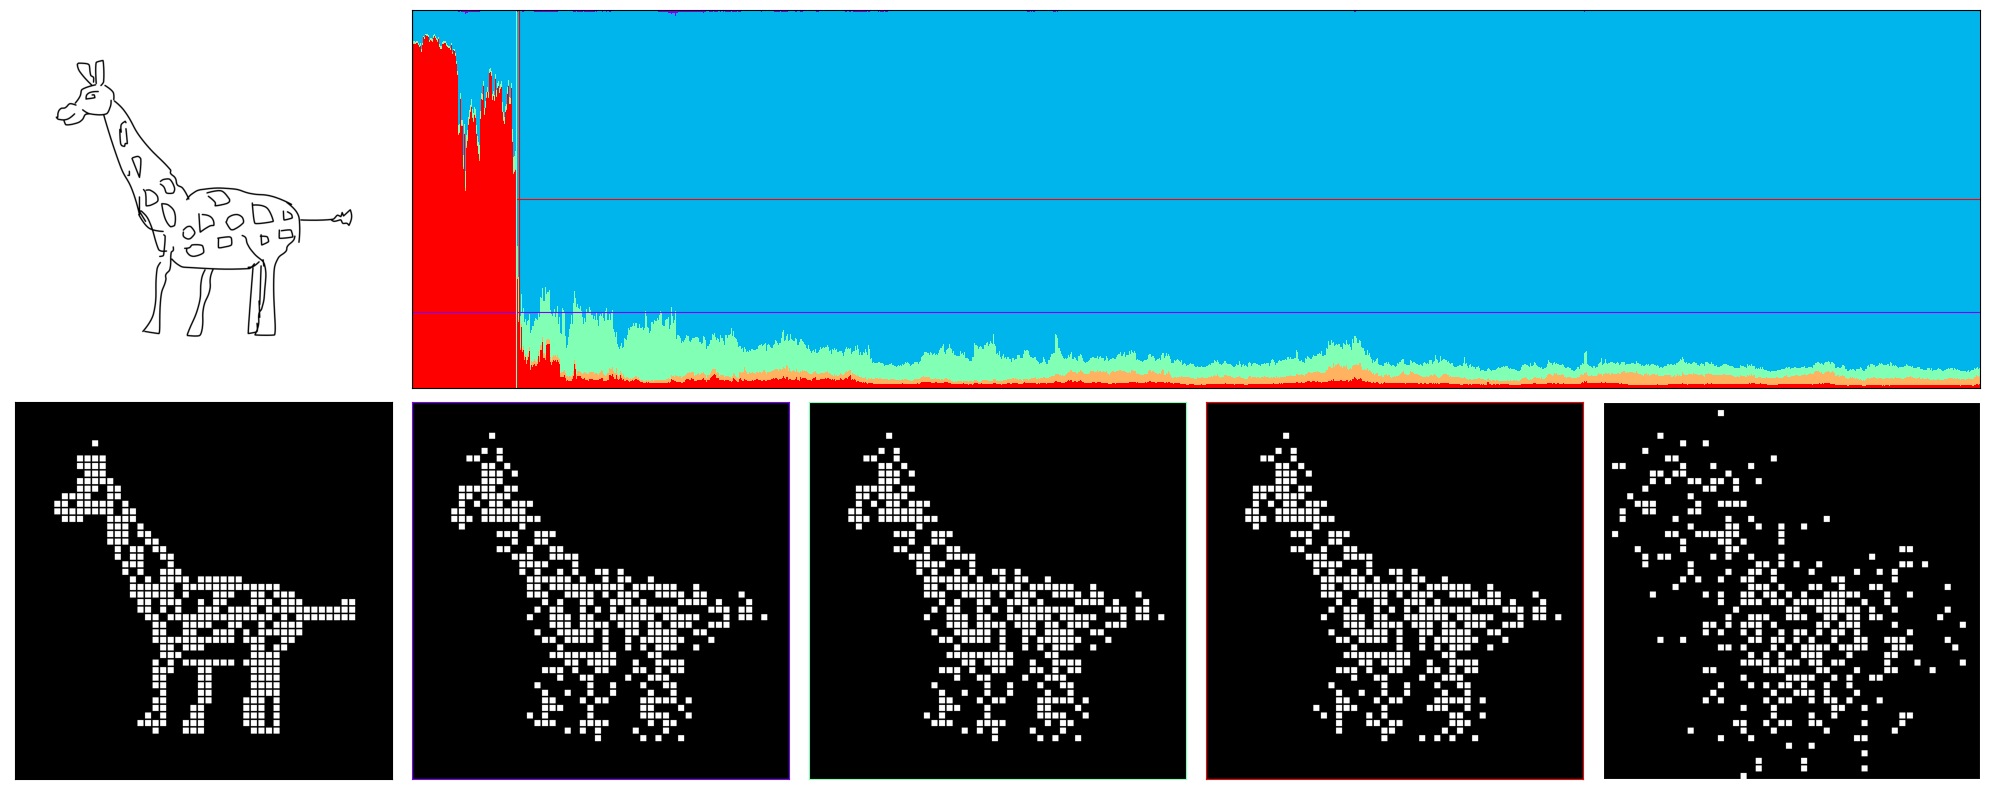

In [39]:
%matplotlib inline
fig = plt.figure(figsize=(20, 8))
grid = plt.GridSpec(2, 5, fig)

axo = plt.subplot(grid[0, 0])
axb = plt.subplot(grid[0, 1:])
axs = [plt.subplot(grid[1, i]) for i in range(5)]

original = Im(FILE, CATEGORY)
original.register(GRID_WIDTH, GRID_HEIGHT, GRIDCELL_SIZE, render_w_grid=RENDER_W_GRID)

axo.imshow(original.image, cmap='binary')
axo.axis('off')
axo.margins(0, 0)

bottom = 0
for i in range(len(categories)):
    axb.bar(results_keys, results_values[:, i], 1, bottom=bottom, label=categories[i], color=colors[i])
    bottom += results_values[:, i]
axb.tick_params(labelbottom=False, labelleft=False)
vc = list(plt.cm.rainbow(np.linspace(0, 1, len(axs) - 2)))
axb.axhline(1/len(categories), c=vc[0], lw=0.8)
axb.axhline(0.5, c=vc[-1], lw=0.8)
vci = iter(vc)
axb.axvline(results_keys[0], c='k', lw=0.8)
axb.axvline(hali, c=next(vci), lw=0.8)
axb.axvline(maxi, c=next(vci), lw=0.8)
axb.axvline(cuti, c=next(vci), lw=0.8)
axb.axvline(results_keys[-1], c='w', lw=0.8)
axb.margins(0, 0)
axb.set_xticks([])
axb.set_yticks([])
# axb.legend()

axs[0].imshow(Im(f"{FILE.split('.')[0]}_0.png", CATEGORY, preprocessed_path).image, cmap='binary')
axs[1].imshow(Im(f'{hali}.png', CATEGORY, preprocessed_path).image, cmap='binary')
axs[2].imshow(Im(f'{maxi}.png', CATEGORY, preprocessed_path).image, cmap='binary')
axs[3].imshow(Im(f'{cuti}.png', CATEGORY, preprocessed_path).image, cmap='binary')
axs[4].imshow(Im(f"{FILE.split('.')[0]}_{FRAMES - 1}.png", CATEGORY, preprocessed_path).image, cmap='binary')

for ax, c in zip(axs, ['k'] + vc + ['w']):
    ax.margins(0, 0)
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_edgecolor(c)

grid.tight_layout(fig)

---

In [40]:
frames = cutf
interval = FRAMES*INTERVAL/frames

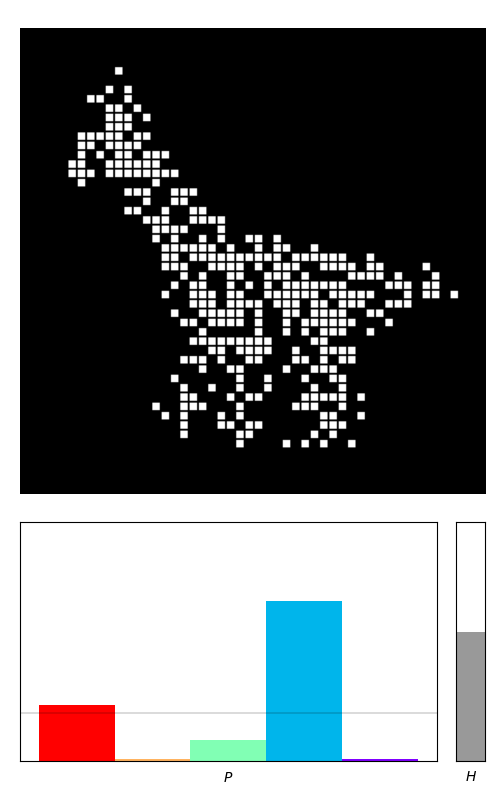

In [41]:
%matplotlib widget
animpath = file.path.with_suffix('') / 'results' / f'animation_{GRID_WIDTH}_{GRID_HEIGHT}_{GRIDCELL_SIZE}_{RENDER_W_GRID}_{N_LABELS}_{SEED}_{frames}_{interval:.0f}.mp4'
# if not animpath.is_file() or OVERWRITE:
fig = plt.figure(figsize=(5, 8))
grid = plt.GridSpec(3, 10, fig)

axi = plt.subplot(grid[:2, :])
axh = plt.subplot(grid[2, :-1])
axe = plt.subplot(grid[2, -1])

image = axi.imshow(file.image, cmap='binary')
axi.axis('off')
axi.margins(0, 0)

histogram = axh.bar(categories, [0]*len(categories), 1, color=colors)
axh.set_xlabel(r'$P$')
axh.set_xticks([])
axh.set_yticks([])
axh.axhline(1/len(categories), c='k', lw='0.2')
axh.grid(True, axis='y')
axh.set_ylim(0, 1)

entropy_graph = axe.bar(r'$H$', 1.2, color='0.6')
axe.tick_params(bottom=False)
axe.set_yticks([])
axe.margins(0, 0)
axe.set_ylim(0, np.log(len(categories)))

grid.tight_layout(fig)

def update(i):
    for y, rect in zip(results_values[i], histogram.patches):
        image.set_data(Im(f'{results_keys[i]}.png', CATEGORY, preprocessed_path).image)
        rect.set_height(y)
        entropy_graph.patches[0].set_height(round(-results_values[i] @ np.log(results_values[i]), 2))
    return histogram.patches

anim = animation.FuncAnimation(fig, update, frames=frames, interval=interval, blit=False, repeat=False)
# animation.FuncAnimation(fig, update, frames=int((t_b - t_a)/speed*sfps), interval=int(1000/sfps), blit=BLIT)

anim.save(animpath, writer=animation.FFMpegWriter(fps=1000/interval, bitrate=1000))